In [1]:
import dask.array as da
import napari
import btrack
from tqdm.auto import tqdm
from skimage.io import imshow,  imsave, imread
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import itertools
import json

plt.rcParams["figure.figsize"] = (15,7)

# Loading images

In [2]:
%%time
image = imread('/mnt/DATA/sandbox/lung_on_chip/monolayer/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif')


CPU times: user 1.2 s, sys: 1.54 s, total: 2.75 s
Wall time: 3.05 s


### crop image to dispose of blank z slices

In [3]:
image.shape

(81, 2304, 2304, 4)

In [4]:
image = image[25:45]

In [5]:
image.shape

(20, 2304, 2304, 4)

In [6]:
ch0 = image[...,0]
ch1 = image[...,1]
ch2 = image[...,2]
ch3 = image[...,3]

# Segment images

###### Initialise gpu

In [7]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Mon Oct 31 13:13:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.07    Driver Version: 515.65.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:65:00.0  On |                  Off |
| 30%   35C    P8    32W / 300W |    687MiB / 49140MiB |     12%      Default |
|                               |                      |                  N/A |
+

In [11]:
%%time
# define model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type='cyto')
# define CHANNELS to run segementation on
channels = [0,0]
### define empty mask stack 
mask_stack = []
### iterate over frames
for frame in tqdm(ch3, total = len(ch3)):
    ### run segmentation
    masks, flows, styles, diams = model.eval(frame, diameter=None, flow_threshold=None, channels=channels)
    ### append to mask stack
    mask_stack.append(masks)
mask_stack = np.stack(mask_stack, axis = 0)
#mask_stack.to_zarr(f"/mnt/DATA/sandbox/ch99.zarr/", overwrite=False)

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 4min 20s, sys: 34.9 s, total: 4min 55s
Wall time: 4min 36s


In [12]:
imsave('/mnt/DATA/sandbox/lung_on_chip/monolayer/cropped_[25:45]_masks.tif', mask_stack)

In [8]:
mask_stack = imread('/mnt/DATA/sandbox/lung_on_chip/monolayer/cropped_[25:45]_masks.tif')

### Defining properties to measure similarities of z-slices

Can use these features in latest version of btrack to aid in tracking by comparing features per-frame

In [9]:
props = ('axis_major_length', 
         'axis_minor_length', 
         'eccentricity', 
         'area', 
         'mean_intensity', 
         #'intensity_image', 
         'orientation')

In [13]:
image.shape

(20, 2304, 2304, 4)

In [10]:
objects = btrack.utils.segmentation_to_objects(
    mask_stack, 
    image,
    properties = props)

[INFO][2022/10/31 01:16:07 PM] Localizing objects from segmentation...
[INFO][2022/10/31 01:16:07 PM] Found intensity_image data
[INFO][2022/10/31 01:16:07 PM] Calculating weighted centroids using intensity_image


ValueError: setting an array element with a sequence.

### The issue here is that ``image`` is a multichannel stack and I am trying to extract mean intensity etc which only requires 1 image

In [14]:
objects = btrack.utils.segmentation_to_objects(
    mask_stack, 
    ch1,
    properties = props)

[INFO][2022/10/31 01:17:36 PM] Localizing objects from segmentation...
[INFO][2022/10/31 01:17:36 PM] Found intensity_image data
[INFO][2022/10/31 01:17:36 PM] Calculating weighted centroids using intensity_image
[INFO][2022/10/31 01:17:55 PM] Objects are of type: <class 'dict'>
[INFO][2022/10/31 01:17:55 PM] ...Found 54892 objects in 20 frames.


### see, it works for one channel, but the function that it depends upon (region_props) has multichannel capacity

In [15]:
from skimage.measure import regionprops_table

In [16]:
from skimage import data, util, measure

In [17]:
_centroids = regionprops_table(mask_stack[0], image[0], properties = props)

In [18]:
for i in _centroids:
    print(i)
    print(type(_centroids[i]))

axis_major_length
<class 'numpy.ndarray'>
axis_minor_length
<class 'numpy.ndarray'>
eccentricity
<class 'numpy.ndarray'>
area
<class 'numpy.ndarray'>
mean_intensity-0
<class 'numpy.ndarray'>
mean_intensity-1
<class 'numpy.ndarray'>
mean_intensity-2
<class 'numpy.ndarray'>
mean_intensity-3
<class 'numpy.ndarray'>
orientation
<class 'numpy.ndarray'>


### lazy fix, but want to enable multichannel within btrack

In [25]:
%%time
ch0_objects = btrack.utils.segmentation_to_objects(
    mask_stack, 
    ch0,
    properties = props#('area', 'mean_intensity', 'intensity_image'), 
)
# ch0_objects = [obj for obj in ch0_objects if obj.properties['area'] > 50]

ch1_objects = btrack.utils.segmentation_to_objects(
    mask_stack, 
    ch1,
    properties = props#('area', 'mean_intensity', 'intensity_image'), 
)
# ch0_objects = [obj for obj in ch0_objects if obj.properties['area'] > 50]

ch2_objects = btrack.utils.segmentation_to_objects(
    mask_stack, 
    ch2,
    properties = props#('area', 'mean_intensity', 'intensity_image'), 
)
# ch0_objects = [obj for obj in ch0_objects if obj.properties['area'] > 50]

[INFO][2022/10/31 01:19:51 PM] Localizing objects from segmentation...
[INFO][2022/10/31 01:19:51 PM] Found intensity_image data
[INFO][2022/10/31 01:19:51 PM] Calculating weighted centroids using intensity_image
[INFO][2022/10/31 01:20:09 PM] Objects are of type: <class 'dict'>
[INFO][2022/10/31 01:20:09 PM] ...Found 54892 objects in 20 frames.
[INFO][2022/10/31 01:20:09 PM] Localizing objects from segmentation...
[INFO][2022/10/31 01:20:09 PM] Found intensity_image data
[INFO][2022/10/31 01:20:09 PM] Calculating weighted centroids using intensity_image
[INFO][2022/10/31 01:20:27 PM] Objects are of type: <class 'dict'>
[INFO][2022/10/31 01:20:28 PM] ...Found 54892 objects in 20 frames.
[INFO][2022/10/31 01:20:28 PM] Localizing objects from segmentation...
[INFO][2022/10/31 01:20:28 PM] Found intensity_image data
[INFO][2022/10/31 01:20:28 PM] Calculating weighted centroids using intensity_image
[INFO][2022/10/31 01:20:45 PM] Objects are of type: <class 'dict'>
[INFO][2022/10/31 01:20:

CPU times: user 53 s, sys: 1.47 s, total: 54.5 s
Wall time: 54.5 s


#### is there a better way to do this? ie. multiple channels measured in one localisation step?

In [26]:
from skimage.measure import regionprops_table

In [27]:
image[0].shape

(2304, 2304, 4)

In [28]:
help(regionprops_table)

Help on function regionprops_table in module skimage.measure._regionprops:

regionprops_table(label_image, intensity_image=None, properties=('label', 'bbox'), *, cache=True, separator='-', extra_properties=None)
    Compute image properties and return them as a pandas-compatible table.
    
    The table is a dictionary mapping column names to value arrays. See Notes
    section below for details.
    
    .. versionadded:: 0.16
    
    Parameters
    ----------
    label_image : (N, M[, P]) ndarray
        Labeled input image. Labels with value 0 are ignored.
    intensity_image : (M, N[, P][, C]) ndarray, optional
        Intensity (i.e., input) image with same size as labeled image, plus
        optionally an extra dimension for multichannel data. Currently,
        this extra channel dimension, if present, must be the last axis.
        Default is None.
    
        .. versionchanged:: 0.18.0
            The ability to provide an extra dimension for channels was added.
    propert

In [29]:
regionprops_table(mask_stack[0], image[0], properties = props)

{'axis_major_length': array([27.61314528, 44.15675623, 51.86248481, 52.82087709, 42.00482411,
        24.8778122 , 22.38464245, 29.30473914, 13.53737286, 12.44889767,
        17.89317818,  7.9323679 , 35.59083047, 35.23364256, 28.13561861,
        28.03226329, 21.79512157, 11.5493579 , 46.70435448, 18.56889187,
        12.38033772, 45.82529225, 27.09617353, 34.67432689, 19.38581507,
        35.68831983, 36.92468559, 38.62244761, 18.79867693, 18.82422646,
        44.0873586 , 29.3925982 , 11.66973579, 21.15244063, 10.38441208,
        13.27713553,  9.78784138, 14.91621017, 12.47278736, 20.68405871,
        20.33000702, 31.49389297, 56.87008802, 22.06223887, 17.15876906,
        43.4870492 , 33.02458638, 38.58220419, 47.34070098, 15.83583603,
        26.99566715, 40.4934217 , 32.99766804, 43.32237772, 40.51851547,
        54.28995591, 18.75522665, 26.33012695,  9.35066922, 40.62529759,
        22.911658  , 10.30080349, 11.11402493, 33.23675544, 32.36906694,
         9.63756396, 47.371796

### so it works for a single frame... why not for btrack


In [30]:
help(btrack.utils.segmentation_to_objects)

Help on function segmentation_to_objects in module btrack._localization:

segmentation_to_objects(segmentation: 'Union[np.ndarray, Generator]', intensity_image: 'Optional[Union[np.ndarray, Generator]]' = None, properties: 'Optional[Tuple[str]]' = (), scale: 'Optional[Tuple[float]]' = None, use_weighted_centroid: 'bool' = True, assign_class_ID: 'bool' = False) -> 'List[btypes.PyTrackObject]'
    Convert segmentation to a set of trackable objects.
    
    Parameters
    ----------
    segmentation : np.ndarray, dask.array.core.Array or Generator
        Segmentation can be provided in several different formats. Arrays should
        be ordered as T(Z)YX.
    intensity_image : np.ndarray, dask.array.core.Array or Generator, optional
        Intensity image with same size as segmentation, to be used to calculate
        additional properties. See `skimage.measure.regionprops` for more info.
    properties : tuple of str, optional
        Properties passed to scikit-image regionprops. Thes

In [32]:
mask_stack.shape

(20, 2304, 2304)

In [36]:
mask_stack_test = np.stack((mask_stack, mask_stack, mask_stack, mask_stack), axis = -1)

In [37]:
mask_stack_test.shape

(20, 2304, 2304, 4)

In [38]:
image.shape

(20, 2304, 2304, 4)

In [47]:
objects = btrack.utils.segmentation_to_objects(
    mask_stack_test, 
    image, 
    properties = props)

[INFO][2022/10/31 01:31:00 PM] Localizing objects from segmentation...
[INFO][2022/10/31 01:31:00 PM] Found intensity_image data
[INFO][2022/10/31 01:31:00 PM] Calculating weighted centroids using intensity_image


ValueError: math domain error

In [43]:
objects[-1]

,ID,x,y,z,t,dummy,states,label,prob,axis_major_length,axis_minor_length,eccentricity,area,mean_intensity,orientation
0,7601,1.530983,6.514957,0.0,1350,False,0,5,0.0,4.472136,2.0,0.894427,8,117.0,1.570796


##### Tracking objs

In [43]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:
  # configure the tracker using a config file
  tracker.configure('/home/dayn/analysis/BayesianTracker/models/particle_config.json')
  # append the objects to be tracked
  tracker.append(ch1_objects)
  # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
  tracker.volume = ((0, 2304), (0, 2304))
  # track them (in interactive mode)
  tracker.track_interactive(step_size=100)
  # generate hypotheses and run the global optimizer
  tracker.optimize()
  # get the tracks as a python list
  ch1_tracks = tracker.tracks
  # filter tracks
  ch1_tracks = [track for track in ch1_tracks if len(track) >= 3]
  # optional: get the data in a format for napari
  ch1_data, properties, graph = tracker.to_napari()
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:
  # configure the tracker using a config file
  tracker.configure('/home/dayn/analysis/BayesianTracker/models/particle_config.json')
  # append the objects to be tracked
  tracker.append(ch2_objects)
  # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
  tracker.volume = ((0, 2304), (0, 2304))
  # track them (in interactive mode)
  tracker.track_interactive(step_size=100)
  # generate hypotheses and run the global optimizer
  tracker.optimize()
  # get the tracks as a python list
  ch2_tracks = tracker.tracks
  # filter tracks
  ch2_tracks = [track for track in ch2_tracks if len(track) >= 3]
  # optional: get the data in a format for napari
  ch2_data, properties, graph = tracker.to_napari()

[INFO][2022/09/15 03:27:39 pm] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2022/09/15 03:27:39 pm] btrack (v0.4.5) library imported
[INFO][2022/09/15 03:27:39 pm] Starting BayesianTracker session
[INFO][2022/09/15 03:27:39 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_config.json
[INFO][2022/09/15 03:27:39 pm] Objects are of type: <class 'list'>
[INFO][2022/09/15 03:27:40 pm] Starting tracking... 
[INFO][2022/09/15 03:27:40 pm] Tracking objects in frames 0 to 81 (of 81)...
[INFO][2022/09/15 03:37:17 pm]  - Timing (Bayesian updates: 17.29ms, Linking: 1.11ms)
[INFO][2022/09/15 03:37:17 pm]  - Probabilities (Link: 0.45222, Lost: 1.00000)
[INFO][2022/09/15 03:37:17 pm] SUCCESS.
[INFO][2022/09/15 03:37:17 pm]  - Found 13647 tracks in 81 frames (in 0.0s)
[INFO][2022/09/15 03:37:18 pm]  - Inserted 11169 dummy objects to fill tracking gaps
[INFO][2022/09/15 03:37:18 pm] Loading hypothesis mode

GLPK Integer Optimizer 5.0
54588 rows, 48785 columns, 70276 non-zeros
48785 integer variables, all of which are binary
Preprocessing...
27294 rows, 48785 columns, 70276 non-zeros
48785 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 27294
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
27294 rows, 48785 columns, 70276 non-zeros
*     0: obj =   1.524562731e+05 inf =   0.000e+00 (14006)
Perturbing LP to avoid stalling [880]...
*  4991: obj =   1.051741910e+05 inf =   0.000e+00 (7836)
*  8815: obj =   9.327650459e+04 inf =   0.000e+00 (3119) 3
Removing LP perturbation [11660]...
* 11660: obj =   8.973936652e+04 inf =   0.000e+00 (0) 3
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+ 11660: mip =     not found yet >=              -inf        (1; 0)
+ 11660: >>>>>   8.9739366

[INFO][2022/09/15 03:37:34 pm] Ending BayesianTracker session
[INFO][2022/09/15 03:37:34 pm] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2022/09/15 03:37:34 pm] btrack (v0.4.5) library imported
[INFO][2022/09/15 03:37:34 pm] Starting BayesianTracker session
[INFO][2022/09/15 03:37:34 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_config.json
[INFO][2022/09/15 03:37:34 pm] Objects are of type: <class 'list'>
[INFO][2022/09/15 03:37:34 pm] Starting tracking... 
[INFO][2022/09/15 03:37:34 pm] Tracking objects in frames 0 to 81 (of 81)...
[INFO][2022/09/15 03:47:03 pm]  - Timing (Bayesian updates: 17.48ms, Linking: 1.20ms)
[INFO][2022/09/15 03:47:03 pm]  - Probabilities (Link: 0.44961, Lost: 1.00000)
[INFO][2022/09/15 03:47:03 pm] SUCCESS.
[INFO][2022/09/15 03:47:03 pm]  - Found 13735 tracks in 81 frames (in 0.0s)
[INFO][2022/09/15 03:47:03 pm]  - Inserted 11205 dummy objects to fill tracki

GLPK Integer Optimizer 5.0
54940 rows, 49383 columns, 71296 non-zeros
49383 integer variables, all of which are binary
Preprocessing...
27470 rows, 49383 columns, 71296 non-zeros
49383 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 27470
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
27470 rows, 49383 columns, 71296 non-zeros
*     0: obj =   1.534656399e+05 inf =   0.000e+00 (14425)
Perturbing LP to avoid stalling [918]...
*  4665: obj =   1.098404048e+05 inf =   0.000e+00 (8516)
*  8494: obj =   9.582076397e+04 inf =   0.000e+00 (3705) 3
Removing LP perturbation [11964]...
* 11964: obj =   8.997434805e+04 inf =   0.000e+00 (0) 3
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+ 11964: mip =     not found yet >=              -inf        (1; 0)
+ 11964: >>>>>   8.9974348

[INFO][2022/09/15 03:47:21 pm] Ending BayesianTracker session


In [46]:
import pandas as pd

In [49]:
import xlsxwriter

In [76]:
track

,ID,t,x,y,z,parent,root,state,generation,dummy,eccentricity,axis_major_length,mean_intensity,area,axis_minor_length,orientation
0,103,0,2119.475673,3.149399,0.000000,103,103,5,0,False,0.891357,12.336098,102.764706,51.0,5.591969,-1.306162
1,103,1,2119.475673,3.149399,0.000000,103,103,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
2,103,2,2119.617341,3.541033,0.000000,103,103,5,0,False,0.902592,14.499987,102.475410,61.0,6.242204,-1.312341
3,103,3,2119.765548,3.876715,0.041956,103,103,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
4,103,4,2119.913756,4.212396,0.083911,103,103,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
5,103,5,2120.061963,4.548078,0.125867,103,103,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
6,103,6,2120.322845,3.870953,0.000000,103,103,5,0,False,0.715710,9.065450,104.428571,42.0,6.331287,-0.665313
7,103,7,2120.818509,4.232434,0.178126,103,103,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
8,103,8,2121.314172,4.593914,0.356251,103,103,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
9,103,9,2121.809835,4.955395,0.534377,103,103,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
list(track.to_dict().keys())

['ID',
 't',
 'x',
 'y',
 'z',
 'parent',
 'root',
 'state',
 'generation',
 'dummy',
 'eccentricity',
 'axis_major_length',
 'mean_intensity',
 'area',
 'axis_minor_length',
 'orientation']

In [79]:
test = pd.DataFrame(track.to_dict(), columns = list(track.to_dict().keys()))

In [91]:
# writer = pd.ExcelWriter('/run/user/30046150/gvfs/google-drive:host=gmail.com,user=nthndy/channel1.xlsx', engine='xlsxwriter')
writer = pd.ExcelWriter('/mnt/DATA/sandbox/lung_on_chip/monolayer/initial_tracks/channel1.xlsx', engine='xlsxwriter')
for track in tqdm(ch1_tracks, total = len(ch1_tracks)):
    df = pd.DataFrame(track.to_dict(), columns = list(track.to_dict().keys()))
    df.to_excel(writer, sheet_name = f'track_{track.ID}')
writer.save()

writer = pd.ExcelWriter('/mnt/DATA/sandbox/lung_on_chip/monolayer/initial_tracks/channel2.xlsx', engine='xlsxwriter')
for track in tqdm(ch2_tracks, total = len(ch2_tracks)):
    df = pd.DataFrame(track.to_dict(), columns = list(track.to_dict().keys()))
    df.to_excel(writer, sheet_name = f'track_{track.ID}')
writer.save()

  0%|          | 0/6806 [00:00<?, ?it/s]

Exception ignored in: <function ZipFile.__del__ at 0x7f9071aa4f70>
Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/zipfile.py", line 1816, in __del__
    self.close()
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/zipfile.py", line 1834, in close
    self._write_end_record()
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/zipfile.py", line 1932, in _write_end_record
    self.fp.flush()
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/zipfile.py", line 769, in flush
    self.fp.flush()
OSError: [Errno 95] Operation not supported


  0%|          | 0/6813 [00:00<?, ?it/s]

#### Data pruning

Lots of dummy instances in these tracks which poses the question of whether they should be included at all?

Shall I filter based on border effects?

What about time?

What about MSD?

In [94]:
ch2_dummy_count = 0
ch1_dummy_count = 0
ch2_tracks_final, ch1_tracks_final = [], []
for ch2_track, ch1_track in zip(ch2_tracks, ch1_tracks):
    if any(ch2_track.dummy) == True:
        ch2_dummy_count+=1
    else:
        ch2_tracks_final.append(ch2_track)
    if any(ch1_track.dummy) == True:
        ch1_dummy_count+=1
    else:    
        ch1_tracks_final.append(ch1_track)

In [101]:
track

,ID,t,x,y,z,parent,root,state,generation,dummy,eccentricity,axis_major_length,mean_intensity,area,axis_minor_length,orientation
0,13592,78,5.741651,1987.678929,0.0,13592,13592,5,0,False,0.730352,14.426898,113.442308,104.0,9.854600,-0.695455
1,13592,79,5.741651,1987.678929,0.0,13592,13592,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
2,13592,80,5.930480,1985.827184,0.0,13592,13592,5,0,False,0.523233,14.028194,114.294574,129.0,11.954679,0.495975


In [103]:
max(track.x) - min(track.x)

0.18882906802398125

In [110]:
msd_dict = {}
for track in ch1_tracks_final:
    dx = max(track.x) - min(track.x)
    dy = max(track.y) - min(track.y)
    
    msd = np.sqrt(dx**2 + dy**2)
    msd_list.append(msd)
    
    msd_dict[track.ID] = msd

In [96]:
len(ch1_tracks), len(ch2_tracks)

(6806, 6813)

In [95]:
len(ch1_tracks_final), len(ch2_tracks_final), ch1_dummy_count, ch2_dummy_count

(3994, 3963, 2812, 2843)

(array([ 36., 104., 254., 350., 353., 292., 267., 244., 209., 179., 171.,
        127., 129., 122., 106.,  99., 106.,  88.,  88.,  71.,  56.,  57.,
         66.,  58.,  42.,  33.,  33.,  24.,  25.,  23.,  23.,   9.,  10.,
         10.,  13.,  10.,  13.,   9.,  11.,   4.,   8.,  10.,   7.,   5.,
          3.,   9.,   2.,   2.,   1.,   3.,   1.,   2.,   3.,   1.,   1.,
          2.,   1.,   1.,   2.,   1.,   0.,   0.,   0.,   1.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.]),
 array([ 0.22822859,  1.17297747,  2.11772635,  3.06247523,  4.00722411,
         4.95197299,  5.89672187,  6.84147075,  7.78621963,  8.73096851,
         9.67571739, 10.62046627, 11.56521515, 12.50996403, 13.45471291,
        14.39946179, 15.34421067, 16.28895955, 17.23370842, 18.1784573 ,
        19.12320618, 20.06795506, 21.01270394, 21.95745282, 22.9022017 ,
        23.84695058, 24.79169946, 25.73644834, 26.68119722, 27.6259461 ,
        28.57069498, 29.51544386, 30.46019274, 31.4049

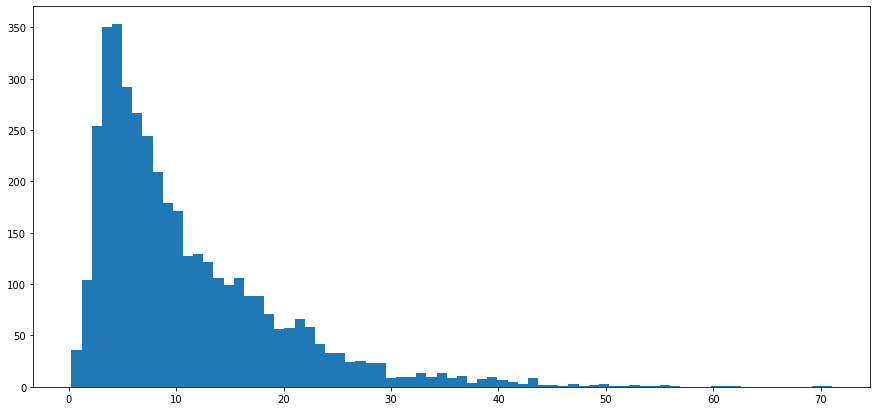

In [123]:
plt.hist(msd_dict.values(), bins = 75)

In [114]:
msd_dict

{93: 10.229813548029325,
 101: 21.56805808566432,
 20: 56.08090705787583,
 237: 14.70273119104523,
 231: 23.732619033123438,
 228: 7.3044351012045015,
 279: 19.066477039522745,
 190: 24.018355039893436,
 187: 12.895741807232266,
 182: 13.642446248795782,
 222: 15.580442842062618,
 196: 15.604853485540056,
 359: 17.487721882257794,
 291: 19.882830257033937,
 384: 34.77402624079604,
 391: 9.136830172249141,
 404: 11.286697763998356,
 442: 26.459974319711318,
 683: 24.218560239654682,
 778: 24.704821166221734,
 719: 10.97083598149322,
 737: 52.81922008520386,
 1062: 29.321192188480207,
 1070: 8.406327822340401,
 1090: 32.750248696458264,
 1183: 10.825563597336458,
 1195: 15.967596822072819,
 1125: 3.695221149386296,
 1227: 26.53725192837205,
 1577: 15.278109162825217,
 1576: 14.780698798650322,
 1575: 8.086960877221673,
 1574: 5.04509502846834,
 1573: 6.400202246775417,
 1570: 17.935481912936382,
 1568: 5.812773164495028,
 1567: 13.07525259633692,
 1566: 8.37232402290349,
 1564: 8.7477349

In [121]:
msd_dict[5560]

2.3681779254079993

In [125]:
[track for track in ch1_tracks if track.ID == 1530][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,eccentricity,axis_major_length,mean_intensity,area,axis_minor_length,orientation
0,1530,25,233.385934,440.519780,0.0,1530,1530,5,0,False,0.977386,18.538067,130.000000,35,3.920079,-0.347033
1,1530,26,241.655335,442.516356,0.0,1530,1530,5,0,False,0.806562,21.928279,165.202020,198,12.962894,1.467627
2,1530,27,254.653963,447.196553,0.0,1530,1530,5,0,False,0.848202,56.687732,147.031722,1324,30.025954,-1.419829
3,1530,28,254.978154,446.804041,0.0,1530,1530,5,0,False,0.836769,51.327993,162.581045,1129,28.104967,-1.423602
4,1530,29,254.137558,446.713158,0.0,1530,1530,5,0,False,0.858614,52.312259,185.113947,1097,26.816418,-1.438871
5,1530,30,252.824050,446.428188,0.0,1530,1530,5,0,False,0.860755,51.213169,223.981818,1045,26.068527,-1.387072
6,1530,31,252.733284,446.398429,0.0,1530,1530,5,0,False,0.861172,53.601834,272.749123,1140,27.246513,-1.413793
7,1530,32,252.214083,446.506238,0.0,1530,1530,5,0,False,0.850413,56.194752,333.192547,1288,29.564963,-1.345897
8,1530,33,251.912873,446.771526,0.0,1530,1530,5,0,False,0.850786,57.085333,434.147147,1332,29.999033,-1.340007
9,1530,34,251.337812,447.117920,0.0,1530,1530,5,0,False,0.855270,56.927165,566.336656,1304,29.498709,-1.363384


In [100]:
ch1_tracks_final[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,eccentricity,axis_major_length,mean_intensity,area,axis_minor_length,orientation
0,93,0,1367.861948,3.606994,0.0,93,93,5,0,False,0.873822,12.571784,107.232143,56,6.112987,-1.144141
1,93,1,1366.374669,3.466766,0.0,93,93,5,0,False,0.850767,12.047942,106.105263,57,6.331710,-1.478019
2,93,2,1357.648063,4.037405,0.0,93,93,5,0,False,0.630600,10.282871,108.661290,62,7.980617,-1.211125
3,93,3,1360.097661,3.932998,0.0,93,93,5,0,False,0.856236,16.512117,106.247525,101,8.529904,-1.456715


In [97]:
ch1_tracks[45]

,ID,t,x,y,z,parent,root,state,generation,dummy,eccentricity,axis_major_length,mean_intensity,area,axis_minor_length,orientation
0,161,0,5.128427,279.942023,0.000000,161,161,5,0,False,0.764726,11.936949,108.895522,67.0,7.691638,1.393213
1,161,1,5.128427,279.942023,0.000000,161,161,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
2,161,2,5.128427,279.942023,0.000000,161,161,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
3,161,3,5.128427,279.942023,0.000000,161,161,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
4,161,4,6.406295,286.768034,0.000000,161,161,5,0,False,0.863035,27.571347,107.774306,288.0,13.927517,-0.114445
5,161,5,8.020586,292.543431,0.655890,161,161,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
6,161,6,6.648208,304.452317,0.000000,161,161,5,0,False,0.670836,14.316921,107.527273,110.0,10.617511,-0.544477
7,161,7,9.947056,315.820911,3.058257,161,161,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
8,161,8,13.245905,327.189504,6.116515,161,161,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
9,161,9,16.544753,338.558098,9.174772,161,161,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN


### Filtering track info to only extract single cell information from t (z) = 34

In [142]:
track

,ID,t,x,y,z,parent,root,state,generation,dummy,eccentricity,axis_major_length,mean_intensity,area,axis_minor_length,orientation
0,1577,25,91.230144,75.737084,0.0,1577,1577,5,0,False,0.848620,20.496205,121.467949,156,10.842558,0.001158
1,1577,26,99.230171,86.128613,0.0,1577,1577,5,0,False,0.749973,42.215498,121.340206,873,27.924237,0.883281
2,1577,27,98.043612,86.030820,0.0,1577,1577,5,0,False,0.730508,40.387230,128.358040,796,27.580607,0.949648
3,1577,28,97.566134,84.680351,0.0,1577,1577,5,0,False,0.778553,41.313242,135.087696,764,25.927299,0.880131
4,1577,29,97.258527,84.379080,0.0,1577,1577,5,0,False,0.801254,42.239200,150.951252,759,25.272758,0.881896
5,1577,30,96.518068,84.147273,0.0,1577,1577,5,0,False,0.755529,41.337669,172.054334,773,27.080934,0.922345
6,1577,31,96.735500,84.216330,0.0,1577,1577,5,0,False,0.772817,42.864393,203.444444,810,27.203000,0.909533
7,1577,32,97.060793,85.334723,0.0,1577,1577,5,0,False,0.735246,42.828771,241.310424,873,29.029370,0.925244
8,1577,33,98.408368,87.217463,0.0,1577,1577,5,0,False,0.723771,43.946058,287.200614,977,30.324569,0.996355
9,1577,34,100.462325,87.910311,0.0,1577,1577,5,0,False,0.702512,42.818166,320.212185,952,30.472473,1.107434


In [157]:
temp_ch1_list, temp_ch2_list = [], []
for ch1_track, ch2_track in zip(ch1_tracks_final, ch2_tracks_final):
    if 34 in ch1_track.t:
        index = ch1_track.t.index(34)
        x, y, ID = ch1_track.x[index], ch1_track.y[index], ch1_track.ID
        mean_int, area = ch1_track.properties['mean_intensity'][index], ch1_track.properties['area'][index]
        temp_ch1_list.append((ID, x, y, mean_int, area))
    if 34 in ch2_track.t:
        index = ch2_track.t.index(34)
        x, y, ID = ch2_track.x[index], ch2_track.y[index], ch2_track.ID
        mean_int, area = ch2_track.properties['mean_intensity'][index], ch2_track.properties['area'][index]
        temp_ch2_list.append((ID, x, y, mean_int, area))
mean_ch1_int_df = pd.DataFrame(temp_ch1_list, columns=['Cell ID', 'X', 'Y', 'Mean Ch1 Intensity', 'Area'])
mean_ch2_int_df = pd.DataFrame(temp_ch2_list, columns=['Cell ID', 'X', 'Y', 'Mean Ch2 Intensity', 'Area'])

In [158]:
mean_ch1_int_df

,Cell ID,X,Y,Mean Ch1 Intensity,Area
0,1577,100.462325,87.910311,320.212185,952
1,1576,452.788301,85.060261,394.222535,710
2,1575,553.970194,92.737568,219.454425,1514
3,1574,587.629630,81.916129,415.998548,1377
4,1573,413.324561,80.101576,199.236448,867
...,...,...,...,...,...
3678,9079,1392.899247,2035.045927,123.525351,927
3679,9081,256.845940,2072.159537,133.262774,411
3680,9082,2092.305860,2052.424437,149.401961,204
3681,9093,263.173409,2254.701879,138.332960,3568


In [159]:
mean_ch2_int_df

,Cell ID,X,Y,Mean Ch2 Intensity,Area
0,1579,1184.220037,20.102867,365.539889,1078
1,1561,1349.737976,91.166578,547.103924,943
2,1577,102.494424,87.886710,599.559874,952
3,1576,452.561108,85.950869,617.294366,710
4,1575,553.609127,95.039185,419.852708,1514
...,...,...,...,...,...
3661,9104,879.822678,2263.338207,160.522326,2150
3662,9086,1392.929678,2035.102305,175.891046,927
3663,9088,257.090411,2072.899681,264.727494,411
3664,9089,2092.651720,2051.888099,287.632353,204


### Save out dataframes as excel sheets

In [160]:
writer = pd.ExcelWriter('/mnt/DATA/sandbox/lung_on_chip/monolayer/initial_tracks/initial_single_cell_measurements_z34_20x_21-12-031B_A12456.xlsx', engine='xlsxwriter')
mean_ch2_int_df.to_excel(writer, sheet_name = 'channel2')
mean_ch1_int_df.to_excel(writer, sheet_name = 'channel1')
writer.save()

## Checking tracks prior to plotting single cell info

In [98]:
import napari

In [99]:
viewer = napari.Viewer()

viewer.add_image(ch0, colormap='blue', blending = 'additive')
viewer.add_image(ch3, colormap= 'gray', blending = 'additive')
viewer.add_image(ch1, colormap='red', blending = 'additive')
viewer.add_image(ch2, colormap= 'green', blending = 'additive')

viewer.add_labels(mask_stack)

viewer.add_tracks(ch1_data)
viewer.add_tracks(ch2_data)


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'ch2_data' at 0x7f8b1063b100>

# Extracting single-slice single-cell data

In [162]:
path = '/mnt/DATA/sandbox/lung_on_chip/monolayer'
fn2 = '20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122.vsi - 014 CF405, CF488, CF561, CF638.tif'
fn3 = '20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_236.vsi - 005 CF405, CF488, CF561, CF638.tif'
fn4 = '20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245.vsi - 014 CF405, CF488, CF561, CF638.tif'

In [167]:
f'_245' in fn2

False

In [161]:
### frame_dict is acq_ID:frame of interest
frame_dict = {245:30, 236:37, 122:32}

In [191]:
masks_list = []
ch1_list = []
ch2_list = []
for fn in [fn2, fn3, fn4]:
    print('Loading file:', os.path.join(path, fn))
    image = imread(os.path.join(path, fn))
    ch1, ch2 = image[1], image[2]
    seg_ch = image[3]
    for dict_entry in frame_dict:
        if f'_{dict_entry}' in fn:
            frame = frame_dict[dict_entry]
    print(f'Loading file at frame {frame}:', os.path.join(path, fn))
    image = imread(os.path.join(path, fn))
    ch1, ch2 = image[...,1][frame], image[...,2][frame]
    seg_ch = image[...,3][frame]
    masks, flows, styles, diams = model.eval(seg_ch, diameter=None, flow_threshold=None, channels=channels)
    masks_list.append(masks)
    ch1_list.append(ch1)
    ch2_list.append(ch2)
print('Masks loaded and segmented')
masks = np.stack(masks_list, axis = 0)
ch1 = np.stack(ch1_list)
ch2 = np.stack(ch2_list)
ch1_objects = btrack.utils.segmentation_to_objects(masks, 
                                                    ch1,
                                                    properties = ('area', 'mean_intensity'), )
ch2_objects = btrack.utils.segmentation_to_objects(masks, 
                                                    ch2,
                                                    properties = ('area', 'mean_intensity'), )

Loading file: /mnt/DATA/sandbox/lung_on_chip/monolayer/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122.vsi - 014 CF405, CF488, CF561, CF638.tif
Loading file at frame 32: /mnt/DATA/sandbox/lung_on_chip/monolayer/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122.vsi - 014 CF405, CF488, CF561, CF638.tif
Loading file: /mnt/DATA/sandbox/lung_on_chip/monolayer/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_236.vsi - 005 CF405, CF488, CF561, CF638.tif
Loading file at frame 37: /mnt/DATA/sandbox/lung_on_chip/monolayer/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_236.vsi - 005 CF405, CF488, CF561, CF638.tif
Loading file: /mnt/DATA/sandbox/lung_on_chip/monolayer/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245.vsi - 014 CF405, CF488, CF561, CF638.tif
Loading file at frame 30: /mnt/DATA/sandbox/lung_on_chip/monolayer/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245.vsi - 014 CF405, CF488, CF561, CF638.tif


[INFO][2022/09/16 04:59:47 pm] Localizing objects from segmentation...
[INFO][2022/09/16 04:59:47 pm] Found intensity_image data
[INFO][2022/09/16 04:59:47 pm] Calculating weighted centroids using intensity_image


Masks loaded and segmented


[INFO][2022/09/16 04:59:49 pm] Objects are of type: <class 'dict'>
[INFO][2022/09/16 04:59:49 pm] ...Found 17175 objects in 3 frames.
[INFO][2022/09/16 04:59:49 pm] Localizing objects from segmentation...
[INFO][2022/09/16 04:59:49 pm] Found intensity_image data
[INFO][2022/09/16 04:59:49 pm] Calculating weighted centroids using intensity_image
[INFO][2022/09/16 04:59:53 pm] Objects are of type: <class 'dict'>
[INFO][2022/09/16 04:59:53 pm] ...Found 17175 objects in 3 frames.


### Each time slice in these 2 sets of objects corresponds to a different membrane

In [202]:
_122_ch1_list, _236_ch1_list, _245_ch1_list = [], [], []
for obj in ch1_objects:
    x, y, ID = obj.x, obj.y, obj.ID
    t = obj.t
    mean_int, area = obj.properties['mean_intensity'], obj.properties['area']
    if t == 0:
        _122_ch1_list.append((ID, x, y, mean_int, area))
    if t == 1:
        _236_ch1_list.append((ID, x, y, mean_int, area))
    if t == 2:
        _245_ch1_list.append((ID, x, y, mean_int, area))
_122_mean_ch1_int_df = pd.DataFrame(_122_ch1_list, columns=['Cell ID', 'X', 'Y', 'Mean Ch1 Intensity', 'Area'])
_236_mean_ch1_int_df = pd.DataFrame(_236_ch1_list, columns=['Cell ID', 'X', 'Y', 'Mean Ch1 Intensity', 'Area'])
_245_mean_ch1_int_df = pd.DataFrame(_245_ch1_list, columns=['Cell ID', 'X', 'Y', 'Mean Ch1 Intensity', 'Area'])

In [203]:
_122_ch2_list, _236_ch2_list, _245_ch2_list = [], [], []
for obj in ch2_objects:
    x, y, ID = obj.x, obj.y, obj.ID
    t = obj.t
    mean_int, area = obj.properties['mean_intensity'], obj.properties['area']
    if t == 0:
        _122_ch2_list.append((ID, x, y, mean_int, area))
    if t == 1:
        _236_ch2_list.append((ID, x, y, mean_int, area))
    if t == 2:
        _245_ch2_list.append((ID, x, y, mean_int, area))
_122_mean_ch2_int_df = pd.DataFrame(_122_ch2_list, columns=['Cell ID', 'X', 'Y', 'Mean ch2 Intensity', 'Area'])
_236_mean_ch2_int_df = pd.DataFrame(_236_ch2_list, columns=['Cell ID', 'X', 'Y', 'Mean ch2 Intensity', 'Area'])
_245_mean_ch2_int_df = pd.DataFrame(_245_ch2_list, columns=['Cell ID', 'X', 'Y', 'Mean ch2 Intensity', 'Area'])

In [208]:
ch1_df = _122_mean_ch1_int_df
ch2_df = _122_mean_ch2_int_df
writer = pd.ExcelWriter('/mnt/DATA/sandbox/lung_on_chip/monolayer/initial_tracks/initial_single_cell_measurements_z32_20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122.vsi - 014 CF405, CF488, CF561, CF638.xlsx', engine='xlsxwriter')
ch2_df.to_excel(writer, sheet_name = 'channel2')
ch1_df.to_excel(writer, sheet_name = 'channel1')
writer.save()

In [209]:
ch1_df = _236_mean_ch1_int_df
ch2_df = _236_mean_ch2_int_df
writer = pd.ExcelWriter('/mnt/DATA/sandbox/lung_on_chip/monolayer/initial_tracks/initial_single_cell_measurements_z37_20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_236.vsi - 005 CF405, CF488, CF561, CF638.xlsx', engine='xlsxwriter')
ch2_df.to_excel(writer, sheet_name = 'channel2')
ch1_df.to_excel(writer, sheet_name = 'channel1')
writer.save()

In [210]:
ch1_df = _245_mean_ch1_int_df
ch2_df = _245_mean_ch2_int_df
writer = pd.ExcelWriter('/mnt/DATA/sandbox/lung_on_chip/monolayer/initial_tracks/initial_single_cell_measurements_z30_20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245.vsi - 014 CF405, CF488, CF561, CF638.xlsx', engine='xlsxwriter')
ch2_df.to_excel(writer, sheet_name = 'channel2')
ch1_df.to_excel(writer, sheet_name = 'channel1')
writer.save()